In [17]:
import pandas as pd
import numpy as np
import xarray as xr
import os

In [18]:
summary_dir = '/Trex/test_case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/summary'
# Load data
merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables_with_location_ID_event_ID_and_sur.feather')
local_hour_adjusted_df = pd.read_feather(merged_feather_path)

In [19]:
local_hour_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58245960 entries, 0 to 58245959
Data columns (total 74 columns):
 #   Column           Dtype         
---  ------           -----         
 0   index            int64         
 1   time             datetime64[ns]
 2   lat              float32       
 3   lon              float32       
 4   APPAR_TEMP       float32       
 5   APPAR_TEMP_R     float32       
 6   APPAR_TEMP_U     float32       
 7   EFLX_LH_TOT      float32       
 8   EFLX_LH_TOT_R    float32       
 9   EFLX_LH_TOT_U    float32       
 10  FGR              float32       
 11  FGR_R            float32       
 12  FGR_U            float32       
 13  FIRA             float32       
 14  FIRA_R           float32       
 15  FIRA_U           float32       
 16  FIRE             float32       
 17  FIRE_R           float32       
 18  FIRE_U           float32       
 19  FLDS             float32       
 20  FSA              float32       
 21  FSA_R            float32     

In [20]:
#group by global event ID and count the number of days in each event
event_count = local_hour_adjusted_df.groupby('location_ID')['time'].count().sort_values(ascending=False)
event_count

location_ID
25025    56640
26178    56544
18737    55176
25663    53616
27394    53136
         ...  
27745       48
44369       48
35793       24
44076       24
40348       24
Name: time, Length: 3704, dtype: int64

In [21]:

location_hw_count = (
    local_hour_adjusted_df[['lat', 'lon']]
    .groupby(['lat', 'lon'])
    .size()
    .reset_index(name='count')
    # .query('count / (24 *29) > 40')
)

# Divide count by 24 to get the number of days
location_hw_count['count'] = location_hw_count['count'] / (24 *29)


location_hw_count.reset_index(drop=True, inplace=True)


In [28]:
 location_hw_count[location_hw_count['count'] > 60].info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 115 to 2879
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     244 non-null    float32
 1   lon     244 non-null    float32
 2   count   244 non-null    float64
dtypes: float32(2), float64(1)
memory usage: 5.7 KB


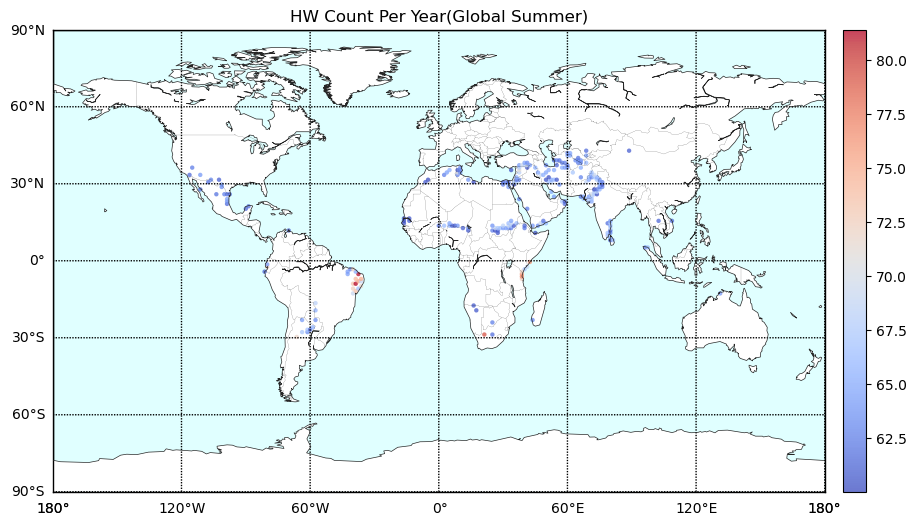

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def normalize_longitude(lons):
    """
    Normalize longitudes to be within the range [-180, 180].
    """
    normalized_lons = np.where(lons > 180, lons - 360, lons)
    return normalized_lons


def draw_map_subplot(ax, title, data, variable):
    if data.empty:
        print(f"No data available for {title}. Skipping plot.")
        ax.set_title(title + " - No Data Available")
        return

    m = Basemap(projection='cyl', lon_0=0, ax=ax,
                fix_aspect=False,
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(color='0.15', linewidth=0.5, zorder=3)
    m.drawcountries(linewidth=0.1)
    m.fillcontinents(color='white', lake_color='lightcyan')
    m.drawmapboundary(fill_color='lightcyan')
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10)

    normalized_lons = normalize_longitude(data['lon'].values)
    x, y = m(normalized_lons, data['lat'].values)

    vmin, vmax = data[variable].min(), data[variable].max()
    sc = m.scatter(x, y, c=data[variable], cmap='coolwarm', marker='o', edgecolor='none', s=10, alpha=0.75, vmin=vmin, vmax=vmax)
    plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
    ax.set_title(title)


fig, ax = plt.subplots(figsize=(12, 6))
    # fig, axs = plt.subplots(figsize=(10, 6), dpi=300)  # Correct subplot structure
draw_map_subplot(ax, "HW Count Per Year(Global Summer)", 
                 location_hw_count[location_hw_count['count'] > 60], 'count')

plt.show()

# Conclusion: will use 60 days as a filtering cut in model training.